In [8]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy as sp 
import sympy as sym 
import SBP as sb 


In [9]:
#### The goal of this notebook is to create a basic structurred mesh generator for my SBP-Solver

nex, ney = 1, 3 # Number of elements in every dimesion
x_min, x_max = -10, 10
y_min, y_max = -10, 10
j = (x_max - x_min)/2
x = np.linspace(x_min, x_max, nex)
y = np.linspace(y_min, y_max, ney)
X = np.zeros((5,5))
X, Y = np.meshgrid(x,y)
print(X)
print(Y)

[[-10.]
 [-10.]
 [-10.]]
[[-10.]
 [  0.]
 [ 10.]]


### Element Class
#### Overview
In order to create the mesh, I will create a class called Element that defines the attributes and methods of that class. 
The Element class has the following attributes: 
 - The Index Number of the element 
 - The boundary points of that element (Maybe define the lgl meshgrid before hand, and simply multiply it by the jacobian)
 - The lgl points to define the meshgrid 
 - Solution points (set to None for now)


The class has the following methods: 
 - A method that prints the solution (coefficients)
 - A method that calculates the Jacobian of that element with respect to the reference element

#### The Jacobian
The reference element is a uniform element that is bounded by $$x\in\{-1,1\} \text{ } y\in\{-1,1\}.$$ 

Now, since the real physical bounds are different, there is a need for a one-to-one mapping between the physical space and the computational space. But, we restrict the physical element to be non-curved and non-skew elements.  
The simplest mapping is done as follows: 

\begin{align*}
x = \frac{x_{max}-x_{min}}{2} \cdot \zeta + \frac{x_{max}+x_{min}}{2} \\
y = \frac{y_{max}-y_{min}}{2} \cdot \eta + \frac{y_{max}+y_{min}}{2}
\end{align*}
where $\zeta \text{ } \& \text{ } x $ are the computational and physical dimensions respectivly. 
Now the Jacobian would lool like: 

\begin{align*}
\textbf{x} = \begin{bmatrix} x \\ u\end{bmatrix} = \begin{bmatrix}\frac{x_{max}-x_{min}}{2} \cdot \zeta + \frac{x_{max}+x_{min}}{2} \\ \frac{y_{max}-y_{min}}{2} \cdot \eta + \frac{y_{max}+y_{min}}{2}\end{bmatrix} \\ 
\partial_{\zeta}  \textbf{x} = \begin{bmatrix} S_x & 0 \\ 0 & S_y \end{bmatrix} \begin{bmatrix} \partial \zeta \\ \partial \eta \end{bmatrix} \\ 
\begin{bmatrix} \partial \zeta \\ \partial \eta \end{bmatrix} = \begin{bmatrix} \frac{1}{S_x} & 0 \\ 0 & \frac{1}{S_y} \end{bmatrix} \begin{bmatrix} \partial x \\ \partial y \end{bmatrix}
\end{align*}



In [10]:
class Element: 
    def __init__(self, index, time , solution, left_bound, right_bound, top_bound, bottom_bound, lgl):
        """
        This class defines a single element. 
        - index: ID of the element 
        - time: Time step
        - solution: solution values 
        - bounds: the physical boundaries of the element
        - lgl: is the set of the lgl points that were used to define the SBP operators
        """
        
        
        self.index = index
        self.time = time
        self.solution = solution
        self.left_bound = left_bound
        self.right_bound = right_bound
        self.top_bound = top_bound
        self.bottom_bound = bottom_bound
        self.lgl = lgl 
        
        
        
    def print_computational_points(self): 
        X, Y = np.meshgrid(self.lgl,self.lgl)
        return X, Y
     
    def print_box(self):
        t = np.array([[self.left_bound, self.right_bound],[self.top_bound,self.top_bound]])
        b = np.array([[self.left_bound, self.right_bound],[self.bottom_bound,self.bottom_bound]])
        l = np.array([ [self.left_bound, self.left_bound], [self.bottom_bound,self.top_bound]])
        r = np.array([[self.right_bound, self.right_bound], [self.bottom_bound,self.top_bound]])
        return plt.plot(t[0],t[1]),plt.plot(b[0],b[1]),  plt.plot(l[0],l[1]), plt.plot(r[0],r[1])
    
    def print_box_with_nodes(self):
        t = np.array([[self.left_bound, self.right_bound],[self.top_bound,self.top_bound]])
        b = np.array([[self.left_bound, self.right_bound],[self.bottom_bound,self.bottom_bound]])
        l = np.array([ [self.left_bound, self.left_bound], [self.bottom_bound,self.top_bound]])
        r = np.array([[self.right_bound, self.right_bound], [self.bottom_bound,self.top_bound]])
        x     = ((self.right_bound-self.left_bound)/2)*self.lgl + ((self.right_bound+self.left_bound)/2)*np.ones_like(self.lgl) 
        y     = ((self.top_bound-self.bottom_bound)/2)*self.lgl + ((self.top_bound+self.bottom_bound)/2)*np.ones_like(self.lgl) 
        X, Y  = np.meshgrid(x, y)
        return plt.plot(t[0],t[1]),plt.plot(b[0],b[1]),  plt.plot(l[0],l[1]), plt.plot(r[0],r[1]), plt.plot(X, Y, "+")
        
        
            
    def print_nodes_physical(self):
        x     = ((self.right_bound-self.left_bound)/2)*self.lgl + ((self.right_bound+self.left_bound)/2)*np.ones_like(self.lgl) 
        y     = ((self.top_bound-self.bottom_bound)/2)*self.lgl + ((self.top_bound+self.bottom_bound)/2)*np.ones_like(self.lgl) 
        X, Y  = np.meshgrid(x, y)
        return X, Y
    
    def Jacob(self): 
        A_physical = (self.right_bound - self.left_bound)*(self.top_bound - self.bottom_bound)
        S_x = (self.right_bound - self.left_bound)/2
        S_y = (self.top_bound - self.bottom_bound)/2  
        inv_jacobian = (S_x*S_y)**(-1)
        return inv_jacobian, A_physical
    
        

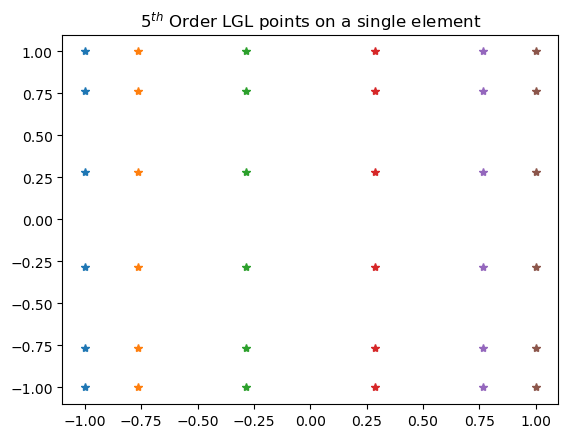

In [20]:

lgl = np.zeros(6)
lgl[:]= sb.lgl(5)[0,:]
e1 = Element(1, 0, 0, 0, 2, 10, 0, lgl)
X, Y = e1.print_computational_points()
plt.plot(X,Y, "*")
#e1.print_box_with_nodes()
plt.title("$5^{th}$ Order LGL points on a single element")
plt.show()

In [13]:
### Creating the class for the mesh element

class Mesh:
    def __init__(self, x_min, x_max,  y_max, y_min , nex, ney, n):
        lgl = np.zeros(n+1)
        lgl[:]= sb.lgl(n)[0,:]
        self.lgl     = lgl
        self.x_min   = x_min
        self.x_max   = x_max
        self.y_min   = y_min
        self.y_max   = y_max
        self.nex     = nex
        self.ney     = ney
        self.elements = [[None for _ in range(ney)] for _ in range(nex)]  # 2D list of elements
        #self.generate_mesh()
        self.t = 0
        
        
    def generate_mesh(self):
        """
        Creates elements and assigns them to the mesh.
        """
        self.solution = None
        dx = (self.x_max - self.x_min) / self.nex
        dy = (self.y_max - self.y_min) / self.ney
        index = 0 # For intializing element IDs 
        
        for i in range(self.nex):
            for j in range(self.ney):
                left_bound = self.x_min + i * dx
                right_bound = self.x_min + (i+1) * dx
                bottom_bound = self.y_min + j * dy
                top_bound = self.y_min + (j+1) * dy

                element = Element( index, self.t , self.solution, left_bound, right_bound, top_bound, bottom_bound, lgl)
                self.elements[i][j] = element
                index += 1

    def get_element(self, i, j):
        """
        Retrieves an element by its (i, j) position in the grid.
        """
        return self.elements[i][j]
    def print_all_elements(self): 
        k = []
        plt.figure(figsize=(6,6))  # Create a figure
        for i in range(self.nex):
            for j in range(self.ney): 
                k = self.elements[i][j]
                k.print_box_with_nodes()
                
                
    #def set_solution_at_time(self,solution):
        
    

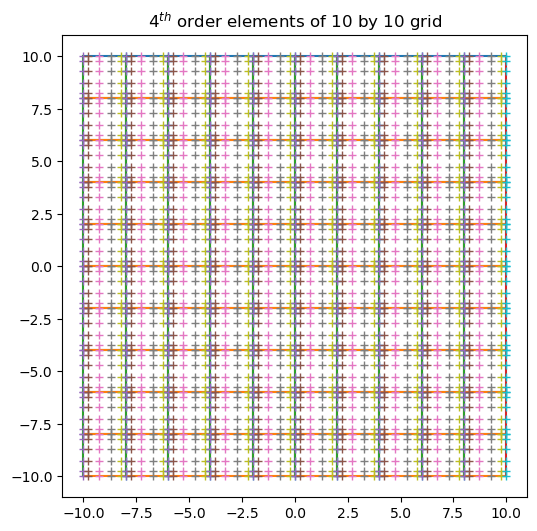

In [14]:
nex = 10 
ney = 10 
m = Mesh(x_min, x_max,  y_max,y_min , nex, ney,5)
m.generate_mesh()

m.print_all_elements()
plt.title("$4^{th}$ order elements of 10 by 10 grid")
plt.show()


In order to properly store the solution, I will define a multidimensional array for that. 
At every time-step, there is a n by n array of solution points. Every solution point has m variables. 
Thus the solution array is a $$U=U_{kijm}$$
where $k$ is the index for time, $i$ and $j$ are the spacial element indicies, and $m$ is the index for the conserved or solution variables.

array([[[[5., 5., 5., 5.],
         [5., 5., 5., 5.],
         [5., 5., 5., 5.],
         [5., 5., 5., 5.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]],


       [[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]],


       [[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

      